In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Function():
    # x : numpy.ndarray
    h = 1e-4
    def __init__(self):
        return

    def f(self, w, others):
        # It must be overridden
        # w : need grad
        # others : do not need grad
        return w

    def grad(self, w, others):
        # may be overridden if f' can be solved analytically
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            fx1 = self.f(w, others)
            w[i] = tmp + self.h
            fx2 = self.f(w, others)
            grads[i] = (fx2-fx1)/(2*self.h)
            w[i] = tmp

        return grads

    def hessian(self, w, others):
        tmp = 0
        hessians = np.zeros([w.size, w.size], dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            grads1 = self.grad(w, others)
            w[i] = tmp + self.h
            grads2 = self.grad(w, others)
            hessians[:, i] = (grads2-grads1)/(2*self.h)
            w[i] = tmp

        return hessians

In [3]:
class P3F(Function):
    def __init__(self, lamb, xs, ys, n, d):
        # n : number of dataset
        # d : data dimension
        K = np.zeros([n, n])
        for i in range(n):
            for j in range(n):
                K[i][j] = ys[i]*ys[j]*np.dot(xs[i], xs[j])

        self.K = K
        self.xs = xs
        self.ys = ys
        self.lamb = lamb
        self.n = n
        self.d = d
        # Lipschitz constant
        e, _ = np.linalg.eigh(K/(2*lamb))
        self.eta = 1/e.max()
        return

    def f(self, alpha, others):
        # do not use others
        w = np.zeros(self.d)
        for i in range(self.n):
            w += alpha[i]*self.ys[i]*self.xs[i]
        w /= (2*self.lamb)

        res = 0
        for i in range(self.n):
            res += max(0, 1-self.ys[i]*np.dot(w, self.xs[i]))
        
        return res
    
    def f_neg_dual(self, alpha, others):
        # do not use others
        return np.dot(np.dot(alpha, self.K), alpha) + sum(alpha)

    def f_dual(self, alpha, others):
        return - self.f_neg_dual(alpha, others)

    def grad_neg_dual(self, alpha, others):
        return 2*np.dot(self.K, alpha)-1

In [4]:
class Optimizer():
    def __init__(self, max_step):
        self.param_history = []
        self.func_history = []
        self.func_history_dual = []
        self.func_history_neg_dual = []
        self.max_step = max_step
    
    def clear(self):
        self.param_history = []
        self.func_history = []
        self.func_history_dual = []
        self.func_history_neg_dual = []

    def PG(self, function, alpha, others, r, ran):
        # PG : projection gradient method
        # function : Function
        # r : stop condition
        # others : only lambda
        self.clear()
        tmp = np.copy(alpha)
        self.param_history.append(tmp)
        self.func_history.append(function.f(tmp, others))
        self.func_history_dual.append(function.f_dual(alpha, others))
        self.func_history_neg_dual.append(function.f_neg_dual(alpha, others))
        count = 0
        while count <= self.max_step:
            grads_neg_dual = function.grad_neg_dual(tmp, others)
            tmp = tmp - function.eta*grads_neg_dual
            tmp = limit(tmp, ran)
                
            tmp = soft_threshold(others[0]*function.eta, tmp)
            self.param_history.append(tmp)
            self.func_history.append(function.f(tmp, others))
            self.func_history_dual.append(function.f_dual(tmp, others))
            self.func_history_neg_dual.append(function.f_neg_dual(tmp, others))
            
            if np.linalg.norm(grads_neg_dual, ord=2) < r:
                break
            count +=1
        return tmp

In [11]:
def soft_threshold(t, x):
    # x : np.ndarray
    res = np.zeros_like(x)
    for i in range(x.size):
        if x[i] >= t:
            res[i] = x[i]-t
        elif x[i] <= -t:
            res[i] = x[i]+t
        else:
            res[i] =  0

    return res

def limit(alpha, ran):
    for i in range(len(alpha)):
        if alpha[i] < ran[0]:
            alpha[i] = ran[0]
        elif alpha[i] > ran[1]:
            alpha[i] = ran[1]
    return alpha

def plot_result(histories, title, labels):
    # histories : [param_history, func_history, func_neg_dual_history]
    fig,ax = plt.subplots()
    for i in range(1, len(histories)):
        ax.plot(list(range(len(histories[i]))), histories[i], label=labels[i])

    ax.set_title(title)
    ax.legend()
    plt.show()

def binary_acc(xs, ys, alpha, lamb):
    acc_count = 0
    w = np.zeros(len(xs[0]))
    for i in range(len(xs)):
        w += alpha[i]*ys[i]*xs[i]
    w /= (2*lamb)
    for x, y in zip(xs, ys):
        if np.dot(w, x) > 0:
            pred = 1
        else:
            pred = -1
        
        if pred==y:
            acc_count +=1

    return acc_count / len(ys)

In [31]:
# making dataset IV
np.random.seed(0)
n = 200
#[[x0], [x1], [x2], ...]
x = 3*(np.random.rand(n,4)-0.5)
y = (2*x[:, 0] - x[:, 1] + 0.5 + 0.5*np.random.randn(n)) > 0
y = 2*y-1
lamb = 0.01

np.random.seed(100)
alpha = np.random.rand(n)

In [32]:
p3f = P3F(lamb, x, y, n, 4)
opt = Optimizer(2048)
histories = []

alpha_opt = opt.PG(function=p3f, alpha=alpha, others=[lamb], r=0.01, ran=[0, 1])
histories = [opt.param_history, opt.func_history, opt.func_history_neg_dual, opt.func_history_dual]

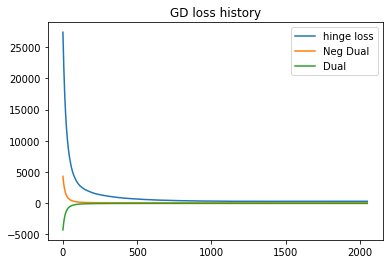

In [33]:
plot_result(histories, 'GD loss history', ['', 'hinge loss', 'Neg Dual', 'Dual'])

In [34]:
print('accuracy')
print('before training : ', binary_acc(x, y, alpha, 0.01))
print('PG : ', binary_acc(x, y, alpha_opt, 0.01))

accuracy
before training :  0.825
PG :  0.86
